# Projet sur les cinémas 

L3 - MIASHS (Maths) 

Pour le 24/04/2024



RAMANGASON Notahiana Erwan

ADJALLA Gael





Le projet consistera à extraire des données stockées dans des fichiers HTML afin alimenter une base de données relationnelle.

### Récuperation des données (webscraping)

In [1]:
#importation des bibliothèques pour la selection des fichier et le formatage des données
from bs4 import BeautifulSoup
from requests import get
import pandas as pd
import os
from datetime import datetime

Pour notre travaille, on va commencer par récupérer les données qui nous sont utilies dans des listes, avant de les rentrer dans notre dataframes qui seront exporté en csv et importé à la base de données



In [2]:
# Création de nos listes

#Listes nécessaires au tableau individus
numInd = []
nom = []
prenom = []
nation = []

#liste nécessaire à la table pour les films
numFilm = []
numReal = []
titre = []
genre = []
annee = []
dateSortie = []
resume = []

#listes nécessaire à la formation de la table des acteurs
numIndAct = []
numFilmAct = []
role = []


Nous allons commencer par définir les fonctions qui nous seront utile

In [3]:
# On va créer une fonction pour récupérer les numéros de films et d'individu, qui se trouvent dans le liens vers leurs page
def numero(lien):
    n = lien.split('=')[1]
    return int(n[:-5])

In [4]:
#On va faire une fonction qui va récupérer les nationalités de nos acteurs sur leur page principal
def nationalite(lien):
    html = get(lien)
    soup = BeautifulSoup(html.text, 'html.parser')

# Après inspection de la page, nous avons vu que la nationalité se trouve dans
    if soup.find('div', {'class': 'dark-grey'}):
        #On choisit de garder seulement la 1ere nationalité et de retirer la virgule pour ne pas gêner le fichier csv
        return soup.find('div', {'class': 'dark-grey'}).text.split(',')[0]
    else:
        # Nous garderons quand même les acteurs même si leur nationalité n'est pas connu
        return ' - '

In [5]:
#Cette fonction permetra d'alimenter la liste des acteurs
def num_role(lien):
    html = get(lien)
    soup = BeautifulSoup(html.text, 'html.parser')
    
    num_film = []
    num_role = []
    role_joue = []
    nom_complet = []
    
    #On commence à vérifier si il y a des acteurs
    if soup.find('div', {'class': 'gd gd-gap-20 gd-xs-2 gd-s-4'}):
        corps = soup.find('div', {'class': 'gd gd-gap-20 gd-xs-2 gd-s-4'})
        if corps.find_all('div', {'class': 'card person-card'}):
            cartes = corps.find_all('div', {'class': 'card person-card'})
            for c in cartes:
                #num_film.append(numero(lien))
                if c.find('a'):
                    #id_role = numero(c.find('a').get('href'))
                    #num_role.append(id_role)
                    if c.find('div', {'class': 'meta-sub light'}):
                        #récupération de numFilm
                        num_film.append(numero(lien))

                        #récuperation de numInd
                        id_role = numero(c.find('a').get('href'))
                        num_role.append(id_role)
                        nom_complet.append(c.find('a').text)

                        #récuperation des rôles
                        cast = c.find('div', {'class': 'meta-sub light'}).text
                        if len(cast.split(': '))>1:
                            cast = cast.split(': ')[1]
                            role_joue.append(cast[:-1])
                        else:
                            role_joue.append(' - ')
                            

                #else:
                    #num_role.append(-2)
                    

    return num_film, num_role, role_joue, nom_complet


In [6]:
# Nettoyage des retour à la ligne
def corrige(texte):
    texte = texte.replace('\n', '')
    return texte.replace('   ', '')

### Récuperation des données en local sur les 100 fichiers

C'est la partie d'essais sur les 100 fichiers

*Passer si vous voulez directement aller à la partie récupération en ligne*

In [ ]:
#repertoire = "LesSortiesCinema_100"
fichier = os.listdir(repertoire)

# Parcours de chaque fichier
for f in fichier:
    chemin = os.path.join(repertoire, f)
    # On vérifie si il s'agit bien d'un fichier:
    if os.path.isfile(chemin):
        with open(chemin, mode = "r", encoding = "utf8") as html:

            # création de l'objet BeautifulSoup
            soup = BeautifulSoup(html, "html.parser")

            
            #Repérer les informations utile du film

            #Récuperation du titre
            title = soup.find("span", {"class": "title"})
            #On remarque que dans certains fichiers, on a des retour à la lignes. On va corriger ca
            titre.append(corrige(title.text))

            #récupération du genre
            content = soup.find("div", {"class": "content"})
            #Il s'agit du premier mot dans notre paragraphe, on va le récuperer
            genre.append(content.text.split()[0])

            #Récupération de la date
            updated = soup.find("span", {"class", "updated"})
            date = updated.text.split()[1]
            #On retire la virgule
            date = date[:-1]
            #Formatage de la date en anglais pour qu'elle soit lisible par mariadb
            date_fr = datetime.strptime(date, "%d/%m/%Y")
            date_ang = date_fr.strftime("%Y/%m/%d")
            dateSortie.append(date_ang)

            #Récupération de l'année
            annee.append(date.split('/')[2])

            #récuperation du contenu
            contenu = content.find("p").text
            if len(contenu.split(' - '))>1:
                contenu = contenu.split(' - ')[1]
                resume.append(corrige(contenu))
            else:
                resume.append(' - ')
            
            #Récuperation des numéros du film qui se trouve dans son lien
            numFilm.append(numero(title.find('a').get('href')))

            #Récupération du numéro du réalisateur du film (en cas de plusieurs, on décide de prendre le premier)
            distribution = content.find_all('p')[1]
            #Vérifions qu'il y en a un
            if distribution.text != '':
                link_real = content.find('a').get('href')
                numReal.append(numero(link_real))


                #Récupération des info nécessaire à la table individu
                individu = distribution.find_all('a')
                for i in individu:
                    #récupération du numéro
                    numInd.append(numero(i.get('href')))

                    #récupération de la nationalité
                    nation.append(nationalite(i.get('href')))

                    #récupération du nom et du prénom
                    complet = []
                    complet = i.text.split()
                    if len(complet)>1:
                        nom.append(complet[-1])
                        prenom.append(' '.join(complet[:-1]))
                    else:
                        nom.append(complet[0])
                        prenom.append(' - ')
                    
                #On récupère les potentiels acteurs qui n'ont pas été présent sur la page du film mais sur sa fiche technique
                

                # Récupération des informations sur les acteurs
                
                #On part du principe qu'il y a toujours un réalisateur et pas forcément d'acteur
                #On commence par récupérer le lien qui mène vers la fiche technique du film
                partie_technique = content.find_all('p')[-1]
                fiche_tech = partie_technique.find('a').get('href')
                #Récuperation des roles du film:
                numFilmAct = numFilmAct + num_role(fiche_tech)[0]
                numIndAct = numIndAct + num_role(fiche_tech)[1]
                role = role + num_role(fiche_tech)[2]
                
                #ajout des acteurs non présent dans la table individu
            
            #Dans le cas où il n'y a pas de réalisateur, nous dirons que son numéro est -1, et evidemment si il n'y a pas de réalisateur il n'y a pas d'acteurs
            else:
                numReal.append(-1)



On vérifiera la taille des listes pour être sur qu'elle font la même taille afin de pouvoir les faire retrer dans nos dataframes

In [7]:
#liste nécessaire à la table des individus
print(len(numInd), len(nom), len(prenom), len(nation))

#liste nécessaire à la table pour les films
print(len(numFilm), len(numReal), len(titre), len(genre), len(annee), len(dateSortie), len(resume))
      
#listes nécessaire à la formation de la table des acteurs
print(len(numIndAct), len(numFilmAct), len(role))

0 0 0 0
0 0 0 0 0 0 0
0 0 0


## Récuperation des données en lignes 

Maintenant qu'il fonctionne correctement sur les 100 fichiers, on va essayer de récuperer les fichiers qui sont en lignes sur la page https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/

In [8]:
url = "https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/"

source = get(url)
soup_art = BeautifulSoup(source.text, 'html.parser')

tableau = soup_art.find('table')
corps = tableau.find_all('tr')

for index, item in enumerate(corps[3:1203]):
    # Le lien est l'url de départ avec le nom de l'article
    lien = url + item.find('a').get('href')
    #Pour suivre où en est la compilation
    print(lien)
    html = get(lien)
    #création de l'objet BeautifulSoup
    soup = BeautifulSoup(html.text, "html.parser")
    
    # Comme on ne peut pas prédire le comportement de la compilation, on va toujours tester
    if soup.find("span", {"class": "title"}):
        if soup.find("div", {"class": "content"}):
            if soup.find("span", {"class", "updated"}):
                # Repérer les informations utile du film

                #récuperation du titre
                title = soup.find("span", {"class": "title"})
                #On remarque que dans certains fichiers, on a des retour à la lignes. On va corriger ca
                titre.append(corrige(title.text))

                #récupération du genre
                content = soup.find("div", {"class": "content"})
                #Il s'agit du premier mot dans notre paragraphe, on va le récuperer
                genre.append(content.text.split()[0])

                #récupération de la date
                updated = soup.find("span", {"class", "updated"})
                date = updated.text.split()[1]
                #On retire la virgule
                date = date[:-1]
                #Le format accepté par mariadb est yyyy/mm/dd, on va donc formater la date pour qu'elle soit compatible
                date_fr = datetime.strptime(date, "%d/%m/%Y")
                date_ang = date_fr.strftime("%Y/%m/%d")
                dateSortie.append(date_ang)

                #récupération de l'année
                annee.append(date.split('/')[2])

                #récuperation du contenu
                if content.find('p'):
                    contenu = content.find("p").text
                    if len(contenu.split(' - '))>1:
                        contenu = contenu.split(' - ')[1]
                        resume.append(corrige(contenu))
                    else:
                        resume.append(' - ')

                    #récuperation des numéros du film qui se trouve dans son lien
                    if title.find('a'):
                        numFilm.append(numero(title.find('a').get('href')))

                        #récupération du numéro du réalisateur du film (en cas de plusieurs, on décide de prendre le premier)
                        distribution = content.find_all('p')[1]
                        #vérifions qu'il y en a un
                        if distribution.text != '':
                            link_real = content.find('a').get('href')
                            numReal.append(numero(link_real))


                            #Récupération des info nécessaire à la table individu
                            individu = distribution.find_all('a')
                            for i in individu:
                                #récupération du numéro
                                numInd.append(numero(i.get('href')))

                                #récupération de la nationalité
                                nation.append(nationalite(i.get('href')))

                                #récupération du nom et du prénom
                                complet = []
                                complet = i.text.split()
                                if len(complet)>1:
                                    nom.append(complet[-1])
                                    prenom.append(' '.join(complet[:-1]))
                                else:
                                    nom.append(complet[0])
                                    prenom.append(' - ')


                            # Récupération des informations sur les acteurs

                            #On part du principe qu'il y a toujours un réalisateur et pas forcément d'acteur
                            #On commence par récupérer le lien qui mène vers la fiche technique du film
                            partie_technique = content.find_all('p')[-1]
                            fiche_tech = partie_technique.find('a').get('href')

                            #Récuperation des roles du film:
                            numFilmAct = numFilmAct + num_role(fiche_tech)[0]
                            numIndAct = numIndAct + num_role(fiche_tech)[1]
                            role = role + num_role(fiche_tech)[2]
                            
                            #On rajoute les acteurs à notre table individu:
                            n = num_role(fiche_tech)[1]
                            name = num_role(fiche_tech)[3]
                            for i in range(len(n)):
                                numInd.append(n[i])
                                nation.append(nationalite('https://www.allocine.fr/personne/fichepersonne_gen_cpersonne=' + str(n[i]) + '.html'))
                                fst = name[i].split() 
                                if len(fst)>1:
                                    nom.append(fst[-1])
                                    prenom.append(' '.join(fst[:-1]))
                                else:
                                    nom.append(fst[0])
                                    prenom.append(' - ')
                            

                    #Dans le cas où il n'y a pas de réalisateur, nous dirons que son numéro est -1, et evidemment si il n'y a pas de réalisateur il n'y a pas d'acteurs
                        else:
                            numReal.append(-1)

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article406.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article407.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article408.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article409.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article410.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article411.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article412.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article413.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article414.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article415.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article416.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCin

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article747.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article748.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article749.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article750.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article751.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article752.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article758.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article759.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article760.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article761.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article762.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCin

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article929.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article930.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article931.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article932.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article933.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article934.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article935.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article936.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article937.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article938.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article939.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCin

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2044.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2045.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2046.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2047.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2048.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2049.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2050.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2051.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2052.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2053.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2054.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2140.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2141.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2142.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2143.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2144.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2145.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2146.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2147.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2148.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2149.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2150.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2262.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2263.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2264.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2265.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2266.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2267.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2268.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2269.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2270.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2271.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2272.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2359.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2360.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2361.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2362.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2363.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2364.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2365.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2366.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2367.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2368.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2369.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2455.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2456.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2457.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2458.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2459.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2460.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2461.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2462.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2463.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2464.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2465.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2551.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2552.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2553.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2554.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2555.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2556.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2557.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2558.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2559.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2560.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2561.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2647.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2648.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2649.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2650.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2651.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2652.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2653.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2654.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2655.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2656.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2657.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2800.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2801.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2802.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2803.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2804.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2805.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2806.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2807.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2808.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2809.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2810.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2896.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2897.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2898.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2899.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2900.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2901.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2902.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2903.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2904.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2905.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2906.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2992.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2993.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2994.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2995.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2996.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2997.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2998.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article2999.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article3000.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article3001.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/LesSortiesCinema/article3002.html
https://mi-phpmut.univ-tlse2.fr/~catherine.comparot/Le

In [16]:
#liste nécessaire à la table des individus
print(len(numInd), len(nom), len(prenom), len(nation))

#liste nécessaire à la table pour les films
print(len(numFilm), len(numReal), len(titre), len(genre), len(annee), len(dateSortie), len(resume))
      
#listes nécessaire à la formation de la table des acteurs
print(len(numIndAct), len(numFilmAct), len(role))

5809 5809 5809 5809
752 752 752 752 752 752 752
2061 2061 2061


### Géneration de nos Dataframe

In [17]:
df_individus = pd.DataFrame({'NumInd': numInd, 'Nom': nom, 'Prenom': prenom, 'Nationalite': nation})
df_films = pd.DataFrame({'NumFilm': numFilm, 'NumInd': numReal, 'Titre': titre, 'Genre': genre, 'Annee': annee, 'DateSortie': dateSortie, 'Resume': resume})
df_acteurs = pd.DataFrame({'NumInd': numIndAct, 'NumFilm': numFilmAct, 'Role': role})

In [18]:
#Rajout de l'individu inexistant qui remplira les réalisateurs quine sont pas là
df_individus = pd.concat([df_individus, pd.DataFrame({'NumInd': [-1], 'Nom': ['néant'], 'Prenom': [' - '], 'Nationalite': [' - ']})], ignore_index = True)
df_individus

,NumInd,Nom,Prenom,Nationalite
0,194480,Bobin,James,Britannique
1,180154,Wasikowska,Mia,Australienne
2,12839,Depp,Johnny,Américain
3,5894,Carter,Helena Bonham,Britannique
4,71932,Cohen,Sacha Baron,Britannique
...,...,...,...,...
5805,1412,Musante,Tony,Américain
5806,5451,Kendall,Suzy,-
5807,5452,Salerno,Enrico Maria,Italien
5808,3766,Renzi,Eva,Allemande


In [19]:
#Suppression des doublons
df_films = df_films.drop_duplicates()
df_individus= df_individus.drop_duplicates()
df_acteurs = df_acteurs.drop_duplicates()

In [ ]:
df_films

In [20]:
df_individus.sort_values(by = "NumInd")

,NumInd,Nom,Prenom,Nationalite
5809,-1,néant,-,-
531,9,Streep,Meryl,Américaine
2629,10,Keitel,Harvey,Américain
3168,16,Lollobrigida,Gina,Italienne
2474,17,Roquevert,Noël,Français
...,...,...,...,...
5394,841171,Erteghaei,Maedeh,-
5393,841173,Rezaei,Marziyeh,Iranienne
5399,841448,Shahrzad,-,Iranienne
5655,843921,Kai,Cao,-


In [21]:
#Création des csv:
df_individus.to_csv('individu.csv', index = False, sep = '\t')
df_acteurs.to_csv('acteur.csv', index = False, sep = '\t')
df_films.to_csv('film.csv', index = False, sep = '\t')

## Travaux statistiques

In [22]:
import matplotlib.pyplot as plt
import numpy as np

### Les films 

Nous allons voir les genres les plus populaires de l'époque

In [23]:
df_films['Genre'].value_counts()

Drame                224
Comédie              147
Documentaire         108
Animation             48
Thriller              38
Action                31
Policier              18
Divers                17
Opera                 17
Aventure              14
Epouvante-horreur     12
Science               11
Fantastique           10
Concert                9
Biopic                 8
Romance                8
Western                5
Historique             5
Famille                3
Guerre                 2
Arts                   2
Musical                2
Découvrez              2
Films;                 2
Tout                   1
...                    1
Top                    1
Retrouvez              1
Les                    1
Show                   1
Cinema                 1
Cinéma                 1
Erotique               1
Name: Genre, dtype: int64

Text(0.5, 1.0, "Nombre d'occurrences par genre")

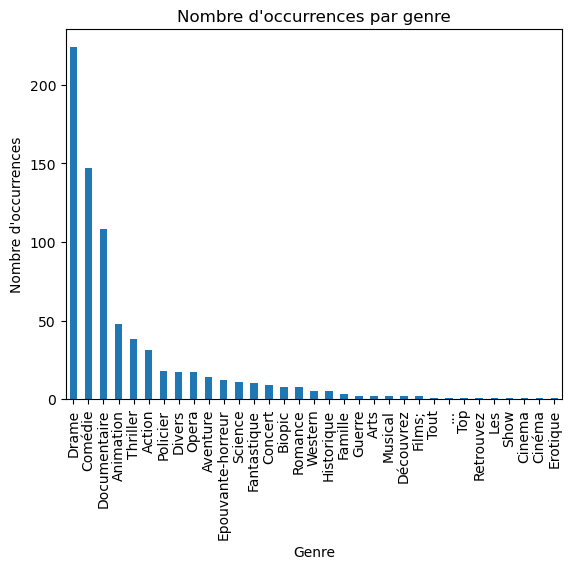

In [24]:
occurrences_genre = df_films['Genre'].value_counts()

# Créer un histograme/barplot
occurrences_genre.plot(kind = 'bar')
#plt.bar(occurrences_genre.index, occurrences_genre)

plt.xlabel('Genre')
plt.ylabel('Nombre d\'occurrences')
plt.title('Nombre d\'occurrences par genre')

In [25]:
viz = df_films.groupby(['Annee', 'Genre']).size().reset_index(name='Nombre')
viz.sort_values(by = 'Nombre', ascending = False)

,Annee,Genre,Nombre
55,2018,Drame,97
35,2017,Drame,89
51,2018,Comédie,62
34,2017,Documentaire,50
31,2017,Comédie,49
...,...,...,...
20,2016,Retrouvez,1
26,2016,Western,1
44,2017,Show,1
16,2016,Les,1


On remarque que le genre le plus populaire et/ou celui qui a été le plus produit est la comédie. Nous allons donc nous concentrer sur ce genre en particulier

In [31]:
df_drame = df_films[df_films['Genre'] == 'Drame']['Resume']
drame = ' '.join(df_drame)

In [ ]:
drame = '''Iremar et sa famille de substitution vivent sur les  routes, travaillant dans le milieu des vaquejadas, rodéos  traditionnels du Nord du Brésil pour lesquels ils préparent les  taureaux. Rêvant de devenir styliste, Iremar accumule étoffes et  paillettes, coupant et assemblant ses créations et les derniers  modèles à la mode… Naïs, jeune paysanne provençale, aime Frédéric,  fils débauché des patrons de son père. Elle devient sa "maîtresse des  vacances". Toine le bossu les surprend, mais, par amour pour Naïs, il  devient leur complice. Micoulin, le père de la jeune fille, met tout  en œuvre pour venger son honneur… Un artiste américain se sent mourir un peu plus  chaque jour, coincé dans son travail de bureau, et assailli par des  visions qui le poussent à remettre sa vie en question. Karim aimerait épouser Faten, une jeune mère  célibataire. Depuis sa séparation, elle vit chez son frère aîné en  attendant de concrétiser son union avec Karim. Ils ont tous deux pour  grand projet de se marier et vivre ensemble.  Dans une petite ville d'Alabama, au moment de la  Grande Dépression, Atticus Finch élève seul ses deux enfants, Jem et  Scout. Avocat intègre et rigoureux, il est commis d'office pour  défendre un homme noir injustement accusé de viol... Masaru et Shinji n’aime pas le lycée. Ils préfèrent  traîner dans les bars, voler et glander. Masi un jour, deux ados  reviennent accompagnés d’un ami boxeur qui met Masaru KO. Il décide  alors de se mettre au Noble Art. Rapidement suivi par Shinji, lequel  va se révéler bien meilleur boxeur. Dépité, Masaru va tenter sa chance  du côté de la pègre locale… En 2003, Larry « Doc » Sheperd, un ancien médecin  de la Navy, retrouve Sal Nealon, un gérant de bar et le révérend  Richard Mueller. Tous les trois ont combattu ensemble au Vietnam mais  ils ne s’étaient pas revus depuis trente ans. En août 1945, au cœur de la Hongrie, un village  s’apprête à célébrer le mariage du fils du notaire tandis que deux  juifs orthodoxes arrivent, chargés de lourdes caisses. Un bruit  circule qu’ils sont les héritiers de déportés et que d’autres, plus  nombreux peuvent revenir réclamer leurs biens. Goa 1999, où vit un grand nombre de Ghatis, des  travailleurs immigrants venus d’autres états d’Inde. Santosh habite  dans un petit village avec sa grand-mère sous la domination de Juze,  leur vendeur de sommeil tyrannique. Il est le seul à lui tenir tête. Né en 1929, Zdzisław Beksiński, peintre surréaliste  polonais connu pour ses inquiétantes œuvres post-apocalyptiques, vit  avec sa femme Zofia, catholique convaincue, et leur fils impulsif et  suicidaire Tomasz, célèbre animateur radio. La disparition soudaine d’une élève d’un lycée pour  jeunes filles précipite la communauté scolaire dans le chaos. Famille  de la victime, enseignants et élèves cherchent à fuir toute  responsabilité, l’image de l’école étant en jeu. Pourtant, sans indice  ni corps, on suspecte un suicide.  Fils d’un ambassadeur à Londres, le jeune Felipe  est confié, en l’absence de ses parents, à la garde de Baines, le  majordome auquel il voue une confiance sans bornes. Felipe découvre  alors que Baines entretient une maîtresse.  Devenu fou, Mabuse, le célèbre criminel, est  interné dans un hôpital psychiatrique. Grâce à l’hypnose, il tient en  son pouvoir Baum, le directeur de l’asile. Ainsi, il parvient à  remettre sur pied une inquiétante bande de malfaiteurs, qui sera  confrontée au commissaire Lohmann... Dans le Japon féodal, alors que les guerres civiles  font rage, les généraux Washizu et Miki rentrent victorieux chez leur  seigneur Tsuzuki. Ils traversent une mystérieuse forêt où ils  rencontrent un esprit qui leur annonce leur destinée... Dans les salons d’un grand hôtel, Iwabuchi,  président d’une importante société immobilière, marie sa fille Yoshiko  à Nishi, son secrétaire particulier. Mais alors que l’on s’apprête à  couper la pièce montée, un second gâteau en forme d’immeuble, dont une  fenêtre est tachée de rouge, est apporté... Dans les bas-fonds d’Edo, à l’écart du reste de la  ville, se tient une auberge miteuse tenue par l’avare Rokubei et sa  femme. Dans cette véritable cour des miracles vivent entre autres un  acteur raté, un ancien samouraï, une prostituée et un voleur. À la fin de l’ère Edo, un samouraï, Sanjuro, arrive  dans un village écartelé entre deux bandes rivales, menées d’un côté  par le bouilleur de saké, de l’autre par le courtier en soie. Les deux  bandes veulent s’adjoindre les services de Sanjuro… Tokyo, 1955. Le chef de famille Kiichi Nakajima  dirige une usine avec ses nombreux enfants. Malgré la prospérité de  son entreprise, le vieil homme souhaite la vendre. En effet, Nakajima  est envahi par la peur d’une nouvelle bombe atomique lâchée sur le  Japon et est prêt à toutes les concessions financières pour s’exiler  au Brésil avec sa famille. Au 19e siècle, Noboru est affecté dans une clinique  où le médecin chef, surnommé Barberousse, est entièrement dévoué à la  cause des déshérités. D'abord réticent, Noboru est peu à peu fasciné  par cet homme au coeur pur... Dans une banlieue populaire de Dakar, les ouvriers  d’un chantier, sans salaire depuis des mois, décident de quitter le  pays par l’océan pour un avenir meilleur. Parmi eux se trouve  Souleiman, qui laisse derrière lui celle qu'il aime, Ada, promise à un  autre homme... Lucius, 73 ans, vit seul et modestement. Un jour,  il fait la connaissance de Lahire qui lui propose d'améliorer son  maigre quotidien en participant à des combats de boxe clandestins. Par  nécessité et parce qu’il sait que ses jours sont comptés, Lucius  accepte la proposition. Enfant d’ouvriers, Kevin, 17 ans, reconsidère la société et  ses injustices quand son meilleur ami Elias lui parle des bienfaits de  la monarchie dans son pays d’origine. La réflexion des deux lycéens à  l’occasion d’un exposé d’Histoire les confrontera à de nombreux  réfractaires. Sam, vingt-deux ans, est une enfant de la DDASS.  Devenue femme mais toujours sous tutelle, elle vit d’arnaques et de  débrouille. Un soir elle rencontre Julie, qu’elle va héberger  temporairement. Daniel, 20 ans, se découvre une vocation  spirituelle dans un centre de détention pour la jeunesse mais le crime  qu'il a commis l'empêche d'accéder aux études de séminariste. Envoyé  dans une petite ville pour travailler dans un atelier de menuiserie,  il se fait passer pour un prêtre et prend la tête de la paroisse. Les effets de la drogue sur la vie de 4 personnes. À trente-trois ans, Mathieu ne sait pas qui est son  père. Un matin, un appel téléphonique lui apprend que celui-ci était  canadien et qu'il vient de mourir. Découvrant aussi qu’il a deux  frères, Mathieu décide d'aller à l'enterrement pour les rencontrer. Dans un ghetto où se côtoient trafics et religion,  Dounia a soif de pouvoir et de réussite. Soutenue par Maimouna, sa  meilleure amie, elle décide de suivre les traces de Rebecca, une  dealeuse respectée. Sa rencontre avec Djigui, un jeune danseur  troublant de sensualité, va bouleverser son quotidien.'''

In [44]:
df_acteurs.iloc[1192]

NumInd           142742
NumFilm          231371
Role       Nuri Şekerci
Name: 1238, dtype: object

## Nuage de mots 

Nous allons dans ce prochain point génerer un message de mot à partir des résumé des textes les plus nombreux, que l'on jugeras important. On va donc commencer par récupérer les résumé dans un fichier

In [ ]:
!pip install wordcloud

In [32]:
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Miadantsoa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [33]:
from nltk.corpus import stopwords
stop = set(stopwords.words('french'))

In [34]:
with open('stop_words_french.txt', mode = 'r', encoding = 'utf-8') as fichier:
    stop_online = fichier.read().splitlines()


Dans les textes, il y a des mots qui n'apportent pas de sens à notre texte ni à notre étude. Ceux sont des 'mots vides' ou stopwords. Pour afficher notre nuage de mot, nous allons donc les retirer pour ne pas embrouiller notre texte

(-0.5, 1199.5, 799.5, -0.5)

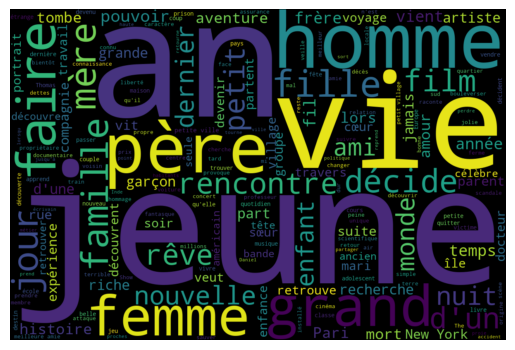

In [35]:
#Affichage avec des stopwords dans une bibliothèque trouvé en ligne
wc = WordCloud(width = 1200, height = 800, stopwords = stop_online).generate(drame)

plt.figure()
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')



(-0.5, 1199.5, 799.5, -0.5)

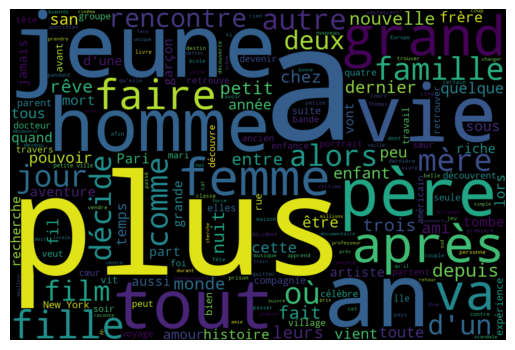

In [36]:
#Nuage de mot dont les stopwords sont dans la bibliothèque ntkl
wc = WordCloud(width = 1200, height = 800, stopwords = stop).generate(drame)

plt.figure()
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')



On peut remarquer que le drame se tourne surtout sur des histoires de jeunesses entre la famille ou entre le couple (homme et femme

## Nouvelle ressources récuperable 

Pour la suite et aussi pour poursuivre l'étude statistique qu'on a entamé, il serait judicieux de récupérer l'avis des notes donné par les spectateurs (à comparer avec ceux de la presse) et ainsi savoir si le genre le plus produit plaisait vraiment aux spectateurs.

Voici donc un début de fonction qui permettrait cette récupération de note

In [ ]:
def note_precis(lien):
    html = get(lien)
    soup = BeautifulSoup(html.text, 'html.parser')
    
    if soup.find('div', {'class': 'content'}):
        content = soup.find('div', {'class': 'content'})
        avis = content.find_all('p')[-1]
        sections = avis.find_all('a')
        note_presse = section[1].get('alt')
        note_spect = section.get('alt')
        
        return int(note_presse), int(note_spect)
        
        